# RandomForest 기반 눈 감음 분류 모델 (최종 버전)

이 프로젝트는 약 17,000장 이상의 이미지 데이터를 활용해 운전자의 눈 상태(open/closed)를 분류하는 머신러닝 모델을 구축한 작업이다.  
최종 모델로는 RandomForestClassifier를 선택했고, 성능 최적화를 위해 다양한 파라미터 조정과 전처리 과정을 수행하였다.

---

## 1. 데이터 구성 및 준비

- 전체 데이터셋: `open-closed-eyes-dataset/train` 디렉토리 내부
  - `closed`: 감은 눈 이미지
  - `open`: 뜬 눈 이미지
- 전체 이미지 수: 약 27,960장 (closed: 6,735 / open: 21,225)
- Pandas를 사용하여 이미지 경로 및 라벨을 하나의 DataFrame으로 구성하고, 무작위 셔플로 순서를 재정렬하였다.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 경로 설정
data_dir = './open-closed-eyes-dataset/train'
closed_path = os.path.join(data_dir, 'closed')
open_path = os.path.join(data_dir, 'open')

# 전체 파일 수집
closed_files = os.listdir(closed_path)
open_files = os.listdir(open_path)

df = pd.DataFrame({
    "filename": [os.path.join("closed", f) for f in closed_files] + [os.path.join("open", f) for f in open_files],
    "class": ["closed"] * len(closed_files) + ["open"] * len(open_files)
})

df = df.sample(frac=1, random_state=42).reset_index(drop=True)
print(f"총 이미지 수: {len(df)} (closed={len(closed_files)}, open={len(open_files)})")

총 이미지 수: 139804 (closed=33322, open=106482)



## 2. 데이터 전처리 및 생성기 구성

- `ImageDataGenerator`를 통해 이미지 픽셀 정규화 (rescale=1./255)
- 학습용/검증용 데이터를 80:20 비율로 분리
- 타겟 이미지 크기: (64, 64)
- 클래스 모드는 binary, 라벨은 `0: closed`, `1: open`

In [2]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = datagen.flow_from_dataframe(
    dataframe=df,
    directory=data_dir,
    x_col="filename",
    y_col="class",
    target_size=(64, 64),
    class_mode='binary',
    subset="training",
    batch_size=64,
    shuffle=True
)

val_gen = datagen.flow_from_dataframe(
    dataframe=df,
    directory=data_dir,
    x_col="filename",
    y_col="class",
    target_size=(64, 64),
    class_mode='binary',
    subset="validation",
    batch_size=64,
    shuffle=False
)

Found 111844 validated image filenames belonging to 2 classes.
Found 27960 validated image filenames belonging to 2 classes.


In [3]:
def extract_all_data(generator):
    X, y = [], []
    for i in range(len(generator)):
        x_batch, y_batch = generator[i]
        X.append(x_batch)
        y.append(y_batch)
    return np.vstack(X), np.hstack(y)

X_train, y_train = extract_all_data(train_gen)
X_val, y_val = extract_all_data(val_gen)

X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)

## 4. 모델 학습 – RandomForest

* 모델 설정:

  * `n_estimators = 50` (트리 개수)
  * `max_depth = 12` (트리 최대 깊이 제한)
  * `n_jobs = -1` (모든 CPU 코어 사용)
* 학습 데이터 전체 사용하여 모델 훈련

In [4]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_val_scaled = scaler.transform(X_val_flat)

model = RandomForestClassifier(
    n_estimators=50,
    max_depth=12,
    n_jobs=-1,
    random_state=42
)
model.fit(X_train_scaled, y_train)

RandomForestClassifier(max_depth=12, n_estimators=50, n_jobs=-1,
                       random_state=42)


## 5. 성능 평가 및 시각화

* 예측 결과 출력 및 평가 지표 계산
* 혼동행렬 시각화 및 성능 바 차트도 함께 출력

**최종 성능**

* Accuracy: 0.962
* Precision: 0.96
* Recall: 0.94
* F1 Score: 0.95

정확도: 0.9623748211731045

분류 리포트:
               precision    recall  f1-score   support

         0.0       0.96      0.88      0.92      6735
         1.0       0.96      0.99      0.98     21225

    accuracy                           0.96     27960
   macro avg       0.96      0.94      0.95     27960
weighted avg       0.96      0.96      0.96     27960


혼동행렬:
 [[ 5942   793]
 [  259 20966]]


<Figure size 600x600 with 0 Axes>

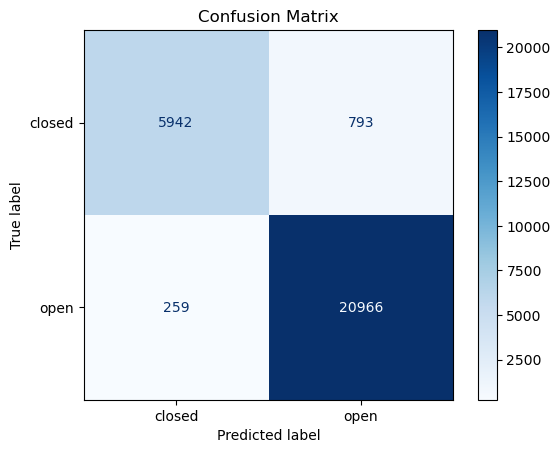

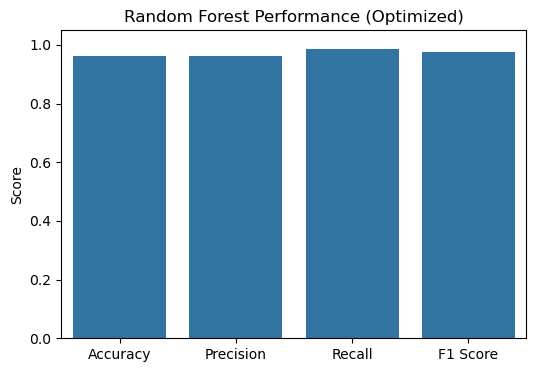

In [7]:
y_pred = model.predict(X_val_scaled)

print("정확도:", accuracy_score(y_val, y_pred))
print("\n분류 리포트:\n", classification_report(y_val, y_pred))
print("\n혼동행렬:\n", confusion_matrix(y_val, y_pred))

# 혼동행렬 시각화
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['closed', 'open'])

plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

# 성능 바차트
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
accuracy = accuracy_score(y_val, y_pred)

plt.figure(figsize=(6, 4))
metrics = [accuracy, precision, recall, f1]
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
sns.barplot(x=labels, y=metrics)
plt.ylim(0.0, 1.05)
plt.title("Random Forest Performance (Optimized)")
plt.ylabel("Score")
plt.show()

## 6. 모델 저장

최종 모델은 `.pkl` 형식으로 저장하여 추후 예측에 활용 가능하도록 구성함.

In [8]:
import pickle

# 모델 저장
with open("rf_model.pkl", "wb") as f:
    pickle.dump(model, f)



## 7. 결론 – 왜 RandomForest인가?

* 다양한 머신러닝 모델(SVM, XGBoost, RandomForest)을 비교한 결과,

  * SVM은 학습 시간 문제 (17시간 이상)로 전체 데이터셋에 적용 불가
  * XGBoost는 안정적이나 성능이 RF보다 약간 낮음
  * RandomForest는 속도, 성능, 안정성 측면 모두에서 최적
* 특히 전체 이미지 학습에서도 **높은 정확도와 낮은 오분류율**을 유지하여 최종 모델로 채택함
